In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score, make_scorer
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import imblearn
from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA



from utils.general_utils import get_outlier_info, get_outlier_val_counts, clean_outliers
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

In [2]:
from scipy import stats

In [3]:
datasetv2_save_path = "dataset/dataset_v2"
imputed_df = pd.read_csv(f'{datasetv2_save_path}/imputed_df.csv', index_col=0)
imputed_df.head()

,pcr,rfs,Age,ER,PgR,LNStatus,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,1.0,144.0,41.0,0.0,0.0,1.0,0.813912,0.724080,23.781937,32.844370,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,142.0,39.0,1.0,1.0,1.0,0.666118,0.476173,20.715461,43.504095,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,135.0,31.0,0.0,0.0,0.0,0.645083,0.594470,21.659822,36.435505,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,12.0,35.0,0.0,0.0,1.0,0.770842,0.501228,26.590504,53.050724,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,109.0,61.0,1.0,0.0,0.0,0.861035,0.750267,20.456571,27.265716,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
train, test = train_test_split(imputed_df, test_size=0.20)

In [5]:
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = imputed_df.drop(columns=categorical_features_labels+['pcr', 'rfs']).columns

In [6]:
train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()

In [7]:
# scalerTrainX = StandardScaler()
# scalerTrainY = StandardScaler()
# scalerTrainX = RobustScaler()
# scalerTrainY = RobustScaler()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))


In [8]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((320, 60), (320, 1), (80, 60), (80, 1))

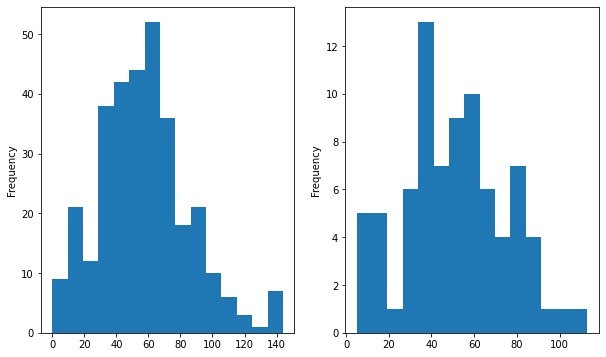

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

train['rfs'].plot(kind='hist', bins=15, ax=axes[0])
test['rfs'].plot(kind='hist', bins=15, ax=axes[1])

plt.show()

In [ ]:
# lower_outlier_gate, upper_outlier_gate = get_outlier_info(imputed_df['rfs'])
# get_outlier_val_counts(imputed_df['rfs'], lower_outlier_gate, upper_outlier_gate)

In [14]:
# criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
criterion = ['squared_error', 'absolute_error']
max_depth = [10, 20, 30, 45, 50, 55, 60]
min_samples_split  = [5, 6, 7, 8, 9, 10, 11, 12, 13]
min_samples_leaf = [2, 3, 4, 5,6,7,8,9,]
max_features = [10, 20, 30, 50, 60]

parameters = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)


In [22]:
regressor = RandomForestRegressor(random_state=0)
regrRF_GS = GridSearchCV(regressor, parameters, scoring=make_scorer(mean_absolute_error))

In [23]:
regrRF_GS.fit(trainX, trainY.ravel())

print('Best Criterion:', regrRF_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', regrRF_GS.best_estimator_.get_params()['max_depth'])
print('Best Number Of min_samples_leaf:', regrRF_GS.best_estimator_.get_params()['min_samples_leaf'])
print('Best Number Of min_samples_split:', regrRF_GS.best_estimator_.get_params()['min_samples_split'])

NameError: name 'clf_GS' is not defined

In [24]:
print('Best Criterion:', regrRF_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', regrRF_GS.best_estimator_.get_params()['max_depth'])
print('Best Number Of min_samples_leaf:', regrRF_GS.best_estimator_.get_params()['min_samples_leaf'])
print('Best Number Of min_samples_split:', regrRF_GS.best_estimator_.get_params()['min_samples_split'])

Best Criterion: absolute_error
Best max_depth: 10
Best Number Of min_samples_leaf: 4
Best Number Of min_samples_split: 5


In [10]:
best_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': 10,
 'max_features': 20,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [11]:
regressor = RandomForestRegressor(**best_params)
regressor.fit(trainX, trainY.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=10, max_features=20,
                      min_samples_leaf=4, min_samples_split=5, random_state=0)

In [12]:
predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.02706745449075203
MAE error: 0.13543605324205293
R2 error: -11.838156581098652


# PCA features

In [41]:
pca = PCA(n_components=6)
pca_6d = pca.fit_transform(trainX)

In [42]:
regressor = RandomForestRegressor(random_state=0, verbose=1)
regressor.fit(pca_6d, trainY.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandomForestRegressor(random_state=0, verbose=1)

In [43]:
predicted = regressor.predict(pca.transform(testX))
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.8434375879196239
MAE error: 0.7172646297280019
R2 error: -6.169478558997657


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


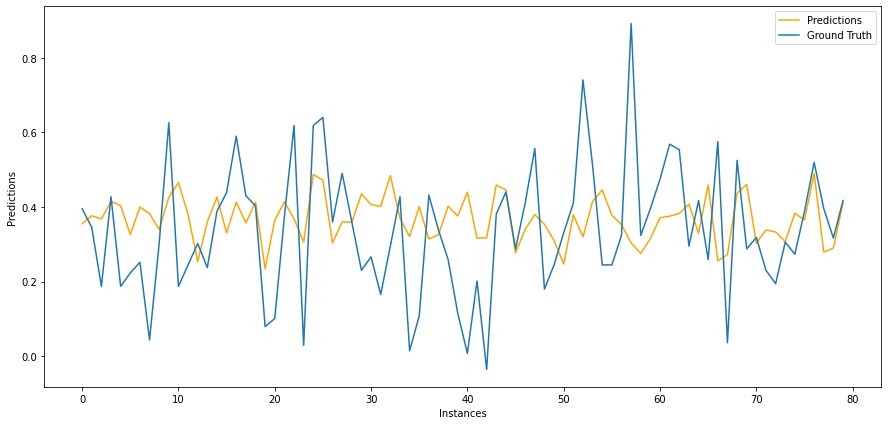

In [28]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), predicted, color='orange', label='Predictions')
plt.plot(list(range(len(predicted))), testY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# Lasso regression for feature selection

In [122]:
from sklearn.linear_model import Lasso

In [46]:
models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
models_to_plot

{1e-15: 231, 1e-10: 232, 0.0001: 233, 0.001: 234, 0.01: 235, 5: 236}

In [131]:
lassoX = imputed_df.drop(columns=['rfs', 'pcr']).to_numpy()
lassoY = imputed_df['rfs'].to_numpy()

In [132]:
scalerLassoX = StandardScaler()
scalerLassoY = StandardScaler()

norm_lassoX = scalerLassoX.fit_transform(lassoX)                   
norm_lassoY = scalerLassoY.fit_transform(lassoY.reshape(1,-1))


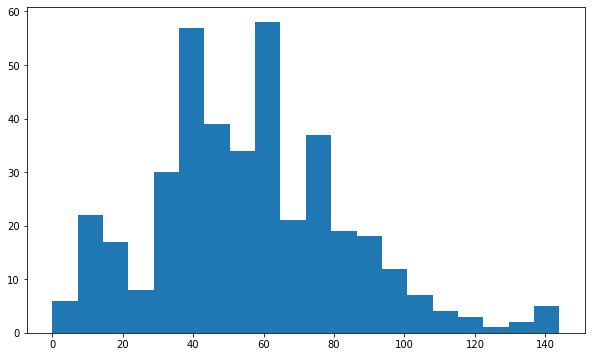

In [139]:

plt.figure(figsize=(10, 6))

plt.hist(lassoY, bins=20)
plt.show()

In [133]:
norm_lassoX.shape, norm_lassoY.shape

((400, 60), (1, 400))

In [134]:
lasso1 = Lasso(alpha=0.0001, max_iter=5000)
lasso1.fit(norm_lassoX, norm_lassoY.ravel())

C:\Users\sudar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0001, max_iter=5000)

In [120]:
lasso1.coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

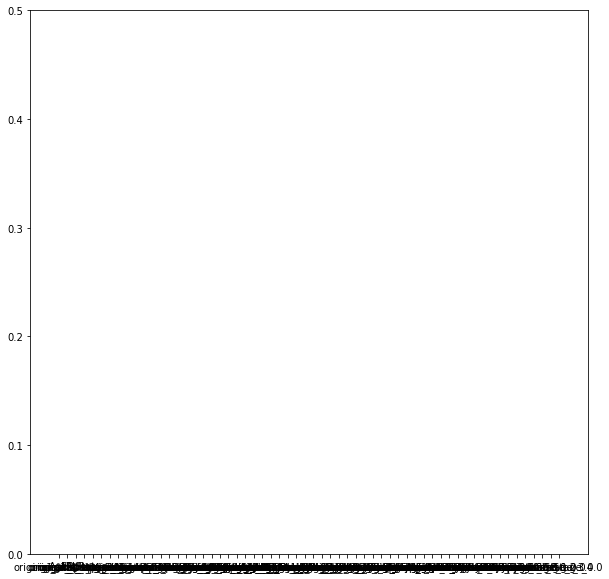

In [111]:
plt.figure(figsize=(10,10))
plt.bar(imputed_df.drop(columns=['pcr','rfs']).columns, np.abs(lasso1.coef_))
# plt.xticks(rotation=90)
# plt.grid()
# plt.title("Feature Selection Based on Lasso")
# plt.xlabel("Features")
# plt.ylabel("Importance")
plt.ylim(0, 0.5)
plt.show()

In [56]:
len(lasso1.coef_)

60

In [60]:
x_axis_features = imputed_df.drop(columns=['pcr','rfs']).columns

Index(['Age'], dtype='object')

In [58]:
lasso1.coef_[lasso1.coef_ > 0.45]

array([0.58532608, 1.23567999, 0.63321825, 0.71311202, 0.77236411,
       0.4719844 ])

# Selecting features which has importance more than 0.45 in Lasso regression

In [82]:
lasso_selected_features = x_axis_features[np.abs(lasso1.coef_) > 0.45]

In [83]:
lasso_selected_features = list(lasso_selected_features)
lasso_selected_features.append('rfs')

In [84]:
lasso_selected_features

['original_shape_SurfaceVolumeRatio',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Skewness',
 'original_glcm_Autocorrelation',
 'original_glrlm_LongRunEmphasis',
 'original_glszm_GrayLevelNonUniformityNormalized',
 'original_glszm_LargeAreaLowGrayLevelEmphasis',
 'original_glszm_SmallAreaEmphasis',
 'original_glszm_ZoneEntropy',
 'rfs']

In [85]:
lasso_selected_df = imputed_df[lasso_selected_features]

In [86]:
lasso_selected_df.head()

,original_shape_SurfaceVolumeRatio,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Skewness,original_glcm_Autocorrelation,original_glrlm_LongRunEmphasis,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,rfs
0,0.258736,-0.163500,0.708860,0.386237,3.328814,36.191087,0.834711,1.170667e+06,0.403535,3.325332,144.0
1,0.330900,0.665558,2.322627,-0.634246,3.934749,109.743182,0.975313,6.010027e+05,0.444391,3.032144,142.0
2,0.359083,0.638035,1.961740,0.545105,3.955045,100.817995,0.973338,3.905040e+05,0.534549,2.485848,135.0
3,0.340781,0.759496,2.164869,-0.792678,3.973627,125.498739,0.980394,1.751932e+06,0.506185,2.606255,12.0
4,0.309200,0.434385,1.832410,-0.732889,3.933264,110.775276,0.966112,3.222760e+05,0.462282,2.809279,109.0


In [87]:
train, test = train_test_split(lasso_selected_df, test_size=0.20)

In [89]:
train.columns

Index(['original_shape_SurfaceVolumeRatio', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Skewness',
       'original_glcm_Autocorrelation', 'original_glrlm_LongRunEmphasis',
       'original_glszm_GrayLevelNonUniformityNormalized',
       'original_glszm_LargeAreaLowGrayLevelEmphasis',
       'original_glszm_SmallAreaEmphasis', 'original_glszm_ZoneEntropy',
       'rfs'],
      dtype='object')

In [90]:
scalerTrainX = StandardScaler()
scalerTrainY = StandardScaler()

trainX = scalerTrainX.fit_transform(train.drop(columns=['rfs']).to_numpy())                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
testX = scalerTrainX.transform(test.drop(columns=['rfs']).to_numpy())                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))


In [143]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((400, 60), (1, 400), (80, 10), (80, 1))

In [165]:
regressor = HistGradientBoostingRegressor(random_state=0, verbose=0,
                                          loss='squared_error', max_iter=100)
regressor.fit(trainX, trainY.ravel())

HistGradientBoostingRegressor(random_state=0)

In [166]:
predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.9930915613577515
MAE error: 0.7973522885566366
R2 error: -4.010842624322039


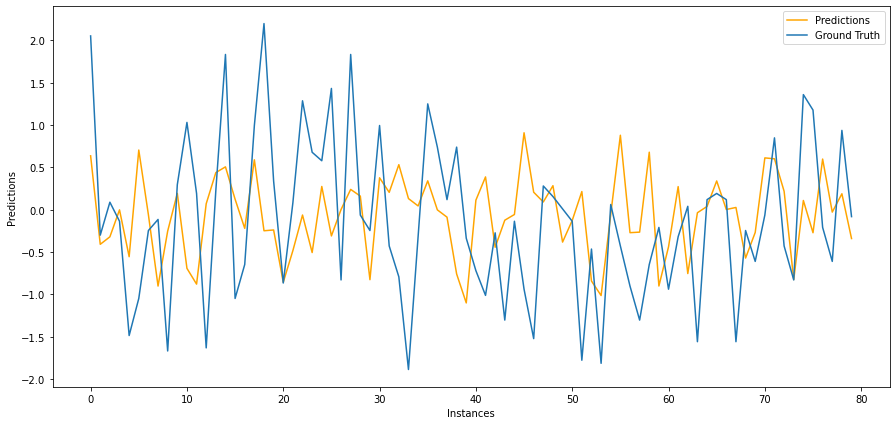

In [155]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), predicted, color='orange', label='Predictions')
plt.plot(list(range(len(predicted))), testY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

## One way ANOVA test for categorical features and RFS

The one-way ANOVA tests the null hypothesis that two or more groups have
the same population mean.  The test is applied to samples from two or
more groups, possibly with differing sizes

In [170]:
from scipy.stats import f_oneway


In [172]:
trainX.shape

(320, 60)

In [176]:
f_oneway(trainX[:,0], trainX[:,1], trainX[:,2])


F_onewayResult(statistic=8.452151207486152, pvalue=0.0002297841831577408)

# Cleaning the outliers by replacing the outlier values with the Upper gate of the quantile plot

In [187]:
outlier_removed_df = imputed_df.drop(columns=['rfs', 'pcr'])

In [188]:
val_dict_list = []

for col in outlier_removed_df.columns:
    
    lower_outlier_gate, upper_outlier_gate = get_outlier_info(outlier_removed_df[col])
    outlier_removed_df = clean_outliers(outlier_removed_df, col, lower_outlier_gate, upper_outlier_gate)
    
    #Sanity Check
    val_dict = get_outlier_val_counts(outlier_removed_df[col], lower_outlier_gate, upper_outlier_gate)
    val_dict_list.append(val_dict)
    
    

            
print(val_dict_list)

[{21.291923749999988: [0, Series([], Name: Age, dtype: float64)], 83.22484575000001: [0, Series([], Name: Age, dtype: float64)]}, {-1.5: [0, Series([], Name: ER, dtype: float64)], 2.5: [0, Series([], Name: ER, dtype: float64)]}, {-1.5: [0, Series([], Name: PgR, dtype: float64)], 2.5: [0, Series([], Name: PgR, dtype: float64)]}, {-1.5: [0, Series([], Name: LNStatus, dtype: float64)], 2.5: [0, Series([], Name: LNStatus, dtype: float64)]}, {0.27522773712500015: [0, Series([], Name: original_shape_Elongation, dtype: float64)], 1.178945288125: [0, Series([], Name: original_shape_Elongation, dtype: float64)]}, {0.017247716499999954: [0, Series([], Name: original_shape_Flatness, dtype: float64)], 1.0910565965: [0, Series([], Name: original_shape_Flatness, dtype: float64)]}, {-0.929200788750002: [0, Series([], Name: original_shape_LeastAxisLength, dtype: float64)], 44.91466886125001: [0, Series([], Name: original_shape_LeastAxisLength, dtype: float64)]}, {-16.195967998750003: [0, Series([], Na

In [189]:
outlier_removed_df['rfs'] = imputed_df['rfs']

In [ ]:
# criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
criterion = ['squared_error', 'absolute_error']
max_depth = [10, 20, 30, 45, 50, 55, 60]
min_samples_split  = [5, 6, 7, 8, 9, 10, 11, 12, 13]
min_samples_leaf = [2, 3, 4, 5,6,7,8,9,]
max_features = [3, 5, 6]

parameters = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)

In [ ]:
df[numeric_columns + '_log'] = df[numeric_columns].apply(lambda x: np.log1p(x))
